In [10]:
# hide
%reload_ext autoreload
%autoreload 2

In [11]:
from dataFunction import *
import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *

random.seed(11007303)
np.random.seed(2021)

In [12]:
# # Parameters
# n_clients = 10
# n_features = 10
# n_observations = 500


In [13]:
# glob_model = LR(n_features)
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()


        

In [14]:
cov_options =[
    [1,2],
    [2,4],
    [1,5],
    [2,6],
    [4,7],
    [2,10],
]

mu_options = [
    [[-2,1,5,-4,2], [-2,1,5,-4,2]] ,
    [[-5,2,-3,-2,1],[-5,1,2,-8,1]] ,
    [[6,3,7,-7,-2], [-2,9,3,-4,5]],
    [[1,5,-6,-2,1], [-3,1,3,-9,2]],
    [[3,-5,-2,-5,1],[-2,4,2,-4,2]]
]

In [91]:
parameters

{'n_option': 2,
 'n_clients': 10,
 'n_features': 10,
 'n_observations': 100,
 'cov_sum': 0.5}

In [100]:
np.random.default_rng().uniform(3, 3.5, size=(1,4))

array([[3.0044606 , 3.44426953, 3.09195596, 3.23492939]])

In [153]:
def KL_divergence(dist1, dist2):
    mu1 = dist1[0]
    cov1 = dist1[1]

    mu2 = dist2[0]
    cov2 = dist2[1]

    mu_dif = mu2 - mu1
    inv_cov2 = np.linalg.inv(cov2)
    trace_cov12 = np.matrix.trace(inv_cov2*cov1)
    det_cov1 = np.linalg.det(cov1)
    det_cov2 = np.linalg.det(cov2)

    return 1/2 *( mu_dif.T @ inv_cov2 @ mu_dif+trace_cov12-np.log(det_cov1/det_cov2)-len(mu1))


In [262]:
n_features

20

In [276]:
for i in cov_random_options:
    random_mu = np.random.randint(-10,10,n_features)
    # rand_cov_num = np.random.default_rng().integers(low=1, high=4)
    cov = np.diag(i*n_features)
    print(i)
    print([random_mu, cov])

[3.43864553 3.01199476]
[array([-7,  7]), array([[6.87729106, 0.        ],
       [0.        , 6.02398951]])]


In [277]:
cov_random_options = np.random.default_rng().uniform(3, (4), size=(n_option, n_clients))

In [279]:
cov_random_options[0] 

array([3.08880352, 3.41911864])

In [281]:
n_option = 1
n_clients = 2
n_features =2 
cov_random_options = np.random.default_rng().uniform(3, (4), size=(n_option, n_clients))
list_dist = make_clients_dist(cov_random_options[0], n_clients, n_features)

In [287]:
np.ones(n_features)*[-10, 3]

array([-10.,   3.])

In [299]:
np.random.randint(-10,10,size=2)

array([-9, -5])

In [308]:
np.array([-9.0, -5.0])+1.5

array([-7.5, -3.5])

In [283]:
list_dist[0]

[array([-10,   3]),
 array([[3.29387224, 0.        ],
        [0.        , 3.29387224]])]

In [367]:
np.arange(0.1, 1, 0.1).round(1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [354]:
plt.savefig('mean_cov_kl_mu:{}.png'.format(mu),bbox_inches='tight',  dpi=300)

<Figure size 432x288 with 0 Axes>

In [382]:
n_clients = 5

In [391]:
mu = np.random.randint(-10,10,n_features)
mu * 1

array([  3, -10])

In [394]:
mean_distance = np.arange(0.1, 3.0, 0.4)

In [398]:
for i in mean_distance:
    print(mu)
    print(mu*i)

[  3 -10]
[ 0.3 -1. ]
[  3 -10]
[ 1.5 -5. ]
[  3 -10]
[ 2.7 -9. ]
[  3 -10]
[  3.9 -13. ]
[  3 -10]
[  5.1 -17. ]
[  3 -10]
[  6.3 -21. ]
[  3 -10]
[  7.5 -25. ]
[  3 -10]
[  8.7 -29. ]


In [438]:
def make_clients_dist(mean_dist, n_clients, n_features):
    clients_distribution = []
    random.seed(11007303)
    np.random.seed(2021)
    random_mu = np.random.randint(-10,10,n_features)
    for i in range(n_clients):
        if i == 0: 
            mu = random_mu
        else:
            mu = np.random.uniform(random_mu, (random_mu * (1+mean_dist)))
        cov = np.diag([1]*n_features)
        clients_distribution.append([mu, cov])
    return clients_distribution

In [439]:
make_clients_dist(0.1, 4, 6)

[[array([-10,   3,   2,   2,  -4,  -4]),
  array([[1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1]])],
 [array([-10.98336126,   3.20309019,   2.1621113 ,   2.04846981,
          -4.12040689,  -4.23020322]),
  array([[1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1]])],
 [array([-10.2839688 ,   3.1939706 ,   2.13580387,   2.11646978,
          -4.30491617,  -4.13897657]),
  array([[1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1]])],
 [array([-10.66059957,   3.14505589,   2.083629  ,   2.17909585,
          -4.09652874,  -4.13364245]),
  array([[1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],


In [409]:
np.random.uniform(mu, (mu * 1.1))

array([  3.05137719, -10.18817477])

In [408]:
np.random.uniform(mu, (mu * 1.1))

array([  3.24893352, -10.4778652 ])

In [443]:
mean_distance = np.arange(0.1, 3.0, 0.1)
mean_distance

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9])

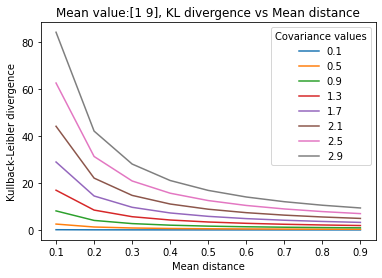

In [376]:
cov_values =np.arange(0.1, 1, 0.1)
mean_distance = np.arange(0.1, 3.0, 0.4)
kl_values = []
mu = np.random.randint(-10,10,size=2)
for m in mean_distance:
    kl_values = []
    for cov_v in cov_values:
        cov = np.diag([cov_v]*n_features)
        kl_values.append(KL_divergence([mu, cov], [mu+(m), cov]))
    plt.plot(cov_values,kl_values)
    plt.xlabel('Mean distance')
    plt.ylabel('Kullback-Leibler divergence')
# plt.tight_layout(pad=2)
plt.legend(mean_distance.round(1), title = "Covariance values")
plt.title('Mean value:{}, KL divergence vs Mean distance'.format(mu))
# plt.set_facecolor('xkcd:salmon')
# plt.savefig('cov_mean_kl_mu:{}.png'.format(mu),bbox_inches='tight',  dpi=300)
plt.show()
    # print('cov: {}, KL:{}'.format(cov_v, KL_divergence([np.ones(n_features), cov], [np.ones(n_features)*1.1, cov])))

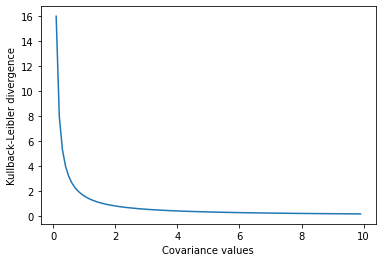

In [198]:
plt.plot(cov_values,kl_values)
plt.xlabel('Covariance values')
plt.ylabel('Kullback-Leibler divergence')
plt.show()

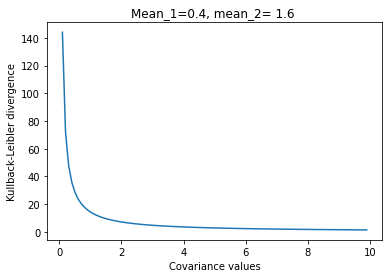

In [201]:
plt.plot(cov_values,kl_values)
plt.xlabel('Covariance values')
plt.ylabel('Kullback-Leibler divergence')
plt.title('Mean_1=0.4, mean_2= 1.6 ')
plt.show()

In [ ]:
# cov_options = [[3, 3.5, 3.2], #total span = 0.5
#                 [3, 2.5, 3.5] # total span = 1
#                 [3, 4, 2], # total span = 2
#                 [3, 1.5, 4.5],# total span = 2
#                 [3, 0.5,  ]] # total span = 5


In [137]:
# N_Options = [10,20,50]
N_Clients = [2,5,10,30]
N_Features = [2,5,10,15,20]
N_Observations = [100,200,500]
N_Options = [10]
# N_Clients = [10]
# N_Features = [10]
# N_Observations = [500]
# cov_sum = [6, 10, 20, 25]
cov_scale = [1 , 5, 10,50, 100, 400, 600, 1000]


iter = 0
Total_dict = {}
for n_option in N_Options:
    for n_clients in N_Clients:
        for cov in cov_scale:
            cov_random_options = np.random.default_rng().uniform(3, (3+cov), size=(n_option, n_clients))
            for n_features in N_Features:
                glob_model = LR(n_features)
                for n_observations in N_Observations:
                    parameters = {}
                    parameters['n_option'] = n_option
                    parameters['n_clients'] = n_clients
                    parameters['n_features'] = n_features
                    parameters['n_observations'] = n_observations
                    parameters['cov_sum'] = cov
                    
                
                    KL_overview = []
                    best_acc_overview = []
                    KL_dict = {}
                    for option in cov_random_options:
                        # for mu in mu_options:
                        # glob_model = LR(n_features)
                        # print(glob_model.state_dict())
                        client_distribution_list = make_clients_dist(option, n_clients, n_features)
                        KL_df, KL_sym_df = make_KL_matrices(n_clients, client_distribution_list)
                        clients = define_clients(client_distribution_list, n_observations,n_features,glob_model)
                        validation_X_set, validation_y_set = make_validation_sets(clients)
                        fl_glob_model = copy.deepcopy(glob_model)
                        best_epoch, best_acc, model_dict, final_results = FL_proces(clients, validation_X_set, validation_y_set, ctx_eval, fl_glob_model, iters= 100)
                        KL_mean = np.array(KL_sym_df)[np.triu_indices(n_clients, k=1)].mean()
                        print('KL divergence with cov: {}, KL:{}, cov_scale:{}, n_clients:{}, n_features:{}'.format(option,  KL_mean, cov, n_clients, n_features))
                        print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  
                        # print(model_dict)
                        # save_results.append([KL_sym_df[0][1],best_acc])
                        KL_overview.append(KL_mean)
                        best_acc_overview.append(float(best_acc))
                    KL_dict['KL'] = KL_overview
                    KL_dict['acc'] = best_acc_overview
                    
                    summary = {}
                    summary['parameters'] = parameters
                    summary['results'] = KL_dict
                    Total_dict[iter] = summary
                    iter += 1
                        
                        # print(final_results)

KL divergence with cov: [3.19510517 3.04823879], KL:0.001107339094147064, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.9750000238418579
KL divergence with cov: [3.39488402 3.39281657], KL:1.85546623399091e-07, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.9750000238418579
KL divergence with cov: [3.47136438 3.6331453 ], KL:0.0010376278274146777, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 98, acc: 0.6000000238418579
KL divergence with cov: [3.73161719 3.128145  ], KL:0.015599136866839225, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.5
KL divergence with cov: [3.39218351 3.520157  ], KL:0.000685754440095887, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 0.75
KL divergence with cov: [3.96406134 3.2086746 ], KL:0.022430692301130595, cov_scale:1, n_clients:2, n_features:2
Best model, iter: 99, acc: 1.0
KL divergence with cov: [3.60924561 3.52120339], KL:0.0003049610802149383, cov_scale:1, n

KeyboardInterrupt: 

In [ ]:
# Total_dict

{0: {'parameters': {'n_option': 4,
   'n_clients': 2,
   'n_features': 10,
   'n_observations': 500,
   'cov_sum': 1},
  'results': {'KL': [0.026906200451908724,
    0.025307346683490994,
    0.0853448942661923,
    0.14285513796721716],
   'acc': [0.550000011920929, 1.0, 0.7450000047683716, 0.6050000190734863]}},
 1: {'parameters': {'n_option': 4,
   'n_clients': 2,
   'n_features': 15,
   'n_observations': 500,
   'cov_sum': 1},
  'results': {'KL': [0.040359300677863974,
    0.037961020025235825,
    0.12801734139928822,
    0.2142827069508253],
   'acc': [0.9950000047683716, 0.9599999785423279, 0.824999988079071, 0.5]}},
 2: {'parameters': {'n_option': 4,
   'n_clients': 2,
   'n_features': 20,
   'n_observations': 500,
   'cov_sum': 1},
  'results': {'KL': [0.05381240090381745,
    0.05061469336698021,
    0.1706897885323828,
    0.28571027593443166],
   'acc': [0.9350000023841858, 0.875, 0.7049999833106995, 0.550000011920929]}},
 3: {'parameters': {'n_option': 4,
   'n_clients': 2

In [ ]:
import json

with open('total_dict_09-6.txt', 'w') as convert_file:
     convert_file.write(json.dumps(Total_dict))

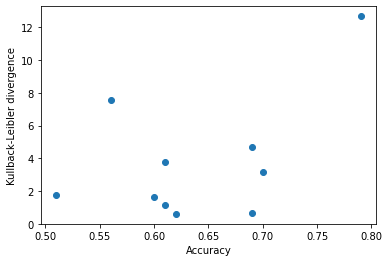

In [16]:
plt.scatter(Total_dict[0]['results']['acc'], Total_dict[0]['results']['KL'])
plt.xlabel('Accuracy')
plt.ylabel('Kullback-Leibler divergence')
plt.show()

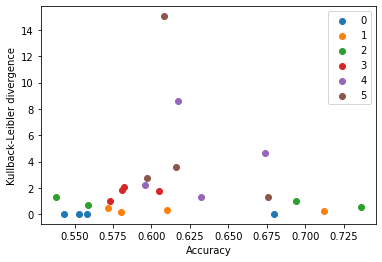

In [120]:
for i in Total_dict.keys():
    plt.scatter(Total_dict[i]['results']['acc'], Total_dict[i]['results']['KL'])
    plt.xlabel('Accuracy')
    plt.ylabel('Kullback-Leibler divergence')
plt.legend(Total_dict.keys())
plt.show()

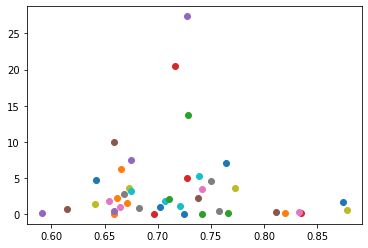

In [135]:
for i in Total_dict.keys():
    # print(np.mean(Total_dict[i]['results']['acc']), np.mean(Total_dict[i]['results']['KL']))
    plt.scatter(np.mean(Total_dict[i]['results']['acc']), np.mean(Total_dict[i]['results']['KL']))
    # plt.xlabel('Accuracy')
    # plt.ylabel('Kullback-Leibler divergence')
# plt.legend(Total_dict.keys())
plt.show()

In [112]:
Total_dict[4]

{'parameters': {'n_option': 2,
  'n_clients': 10,
  'n_features': 10,
  'n_observations': 100,
  'cov_sum': 6},
 'results': {'KL': [0.23957747541812416, 0.591377782046583],
  'acc': [0.8050000071525574, 0.6000000238418579]}}

In [105]:
KL_overview

[0.19650375777069615, 0.04559974651083679]

In [85]:
t = rng.normal(, scale=0.5, size=(n_features,n_clients))

In [86]:
np.mean(t[1])

8.231958140354298

In [87]:
t

array([[7.76685455, 7.88319817, 8.20614663, 7.37599439, 9.02602596,
        7.90861956, 8.01376811, 8.16718369, 8.27763306, 7.48698114],
       [8.05136093, 7.8971121 , 8.24200771, 8.18211363, 8.42399309,
        8.67295415, 8.33723086, 8.12240061, 8.39607928, 7.99432902],
       [7.58183506, 7.81696119, 8.36931231, 7.32654428, 8.15211967,
        7.76099017, 8.38984155, 7.92275317, 7.57137657, 6.84049843],
       [7.13387445, 8.46756188, 8.16569609, 7.68805248, 7.6812488 ,
        8.08419288, 7.93595423, 8.22779563, 7.86648793, 7.63853568],
       [7.87003303, 7.54127241, 8.08985795, 7.99744362, 8.30127437,
        7.80519467, 7.40505816, 8.30239241, 7.45949265, 8.30934516],
       [7.86828842, 7.93128423, 7.43971757, 8.22487304, 7.07381113,
        9.01778617, 8.26445497, 7.68378091, 8.35965706, 8.41705189],
       [7.87339849, 8.21296599, 8.73756344, 8.98874452, 8.59437751,
        7.71049792, 7.16971508, 8.58884576, 8.33307861, 8.21508142],
       [8.12262646, 8.17076985, 8.0098323

In [46]:
n_clients =2

array([[0.34117128, 0.18617294, 0.59414013, 0.01507528, 0.47374021,
        1.19351224, 0.60573007, 1.41584211, 0.63140933, 0.54320639],
       [0.99769788, 0.97143981, 0.86636799, 0.18266549, 1.43919768,
        0.15915721, 0.30513858, 0.19472468, 0.26922356, 0.61438713]])

In [147]:
# N_Options = [10,20,50]]
# N_Clients = [10]
# N_Features = [10]
# N_Observations = [500]
# cov_sum = [6, 10, 20, 25]
# N_Clients = [2,5,10,30]
# N_Features = [2,5,10,15,20]
# N_Observations = [100,200,500]
# N_Options = [10]

# cov_range = [1 , 5, 10,50, 100, 400, 600, 1000]


N_Clients = [2,5,10,30]
N_Features = [2,5,10,15,20]
N_Observations = [100,200,500]
n_option = 10

cov_range = [1 , 5, 10,50, 100, 400, 600, 1000]


In [463]:
3/0.5

6.0

In [482]:
N_Clients = [2,5,10,30]
N_Features = [2,5,10,15,20]
N_Observations = [200]
mean_distance = np.arange(0.1, 3.0, 0.5)
monte_carlo_reps = range(40)
from tqdm import tqdm

In [483]:
iter = 0
# pbar = tqdm(total=6000)   
for n_clients in N_Clients:
    for n_features in N_Features:
        for mean_dist in mean_distance:
            glob_model = LR(n_features)
            for n_observations in N_Observations:
                for mc in monte_carlo_reps:
                    print('inter:{}, mean dist: {}, n_observation:{}, n_clients:{}, n_features:{}, mc:{}'.format(iter, mean_dist, n_observations, n_clients,  n_features, mc))
                    # make_clients_dist(mean_dist, n_clients, n_features)
                iter += 1
                    # pbar.update(1) 

inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:0
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:1
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:2
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:3
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:4
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:5
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:6
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:7
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:8
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:9
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:10
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:11
inter:0, mean dist: 0.1, n_observation:200, n_clients:2, n_features:2, mc:12
inter:0, 

In [378]:
from datetime import datetime
str(datetime.now())

'2022-06-11 17:21:53.163725'

In [454]:
5999+1

6000